In [74]:
import math
import numpy as np
import sys
import time
from pandas import *
from numpy.linalg import matrix_power,norm
from scipy.linalg import logm, expm
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

In [211]:
### DEFINING GLOBAL VARIABLES ###
# Pick
l_sys = 4
d_sys = 2*l_sys + 1

l_env = 4
d_env = 2* l_env + 1

D = d_sys*d_env



# picking alpha and beta nonzero real parameters:
beta_sys = (2*math.pi)/math.sqrt(d_sys)
alpha_sys = (2*math.pi)/(beta_sys*d_sys)

beta_env = (2*math.pi)/math.sqrt(d_env)
alpha_env = (2*math.pi)/(beta_env*d_env)

In [212]:
# =============================== CONSTRUCTING HAMILTONIAN ========================================

def calculate_off_diagonal_pi(row,col,dim, alpha):
    '''Helper function to calculate off diagonal terms of pi matrix according to C13.

       Parameters:
       row (int): The row of the diagonal element.
       col (int): The col of the diagonal element.

       Returns: (int) The calculated diagonal term.
    '''
    first_term = (1j * math.pi)/((2*dim + 1)*alpha)
    second_term = 1/(math.sin((2*math.pi*dim*(row-col))/(2*dim + 1))) #1/sin(x) instead of csc(x)
    return first_term*second_term

def construct_pi(dim,alpha): ##check eigenvalues of pi alone
    '''Function to construct pi matrix of -l to l dimensions according to C13. This matrix corresponds to the momentum of the system.
    
       Parameters: None.
       
       Returns: [[]], The -l*l pi matrix.
       '''
    pi_matrix = []
    for row in range(0,2*dim + 1):
        current_row = []
        for col in range(0,2*dim+1): 
            if row == col:
                current_row.append(0)
            else:
                current_row.append(calculate_off_diagonal_pi(row,col,dim, alpha))
        pi_matrix.append(current_row)

    return pi_matrix


def construct_phi(dim, beta): ##check eigenvalues of phi
    '''Function to construct phi matrix of -l to l dimensions according to C14. This matrix corresponds to the distance from equilibrium.
    
       Parameters: None.
       
       Returns: [[]], the -l*l phi matrix.'''
    phi_matrix = [[0 for i in range(0, 2*dim+1)] for j in range(0, 2*dim+1)]
    for row in range(0, 2*dim+1):
        phi_matrix[row][row] = (row-dim)*((2*math.pi)/((2*dim+1)*beta))
    return phi_matrix


def construct_matrix_a(matrix, d_b):
    '''Calculates tensor product of passed in matrix and identity matrix.
    
       Parameters:
       matrix: An n*n dimension matrix that will be the left side of the tensor product.
       
       Returns: An n^2*n^2 dimension matrix for system A.'''
    # construct identity matrix of correct dimension
    identity_matrix = np.identity(d_b)
    # perform (a) inner_product (I)
    return np.kron(matrix, identity_matrix)

def construct_matrix_b(matrix, d_a):
    '''Calculates tensor product of identity matrix and passed in matrix.
     
       Parameters:
       matrix: An n*n dimension matrix that will be the right side of the tensor product.
       
       Returns: An n^2*n^2 dimension matrix for system B.'''
    # construct identity matrix of correct dimension
    identity_matrix = np.identity(d_a)
    # perform (I) inner_product (b)
    return np.kron(identity_matrix, matrix)

def construct_H(m, omega, pi_matrix, phi_matrix):
    '''Constructs Hamiltonian matrices according to equations 56 and 57.
    
       Parameters:
       m = mass
       omega = frequency 
       pi_matrix = The n*n matrix representation of the position operator.
       phi_matrix = The n*n matrix represenation of the momentum operator.
       
       Returns:
       The n*n matrix representation of the Hamiltonian operator constructed according to 56.'''
    return matrix_power(np.matrix(pi_matrix),2)/(2*m) + 0.5*m*(omega**2)*(matrix_power(np.matrix(phi_matrix),2))

def construct_H_int(phi_a, phi_b, lambda_var):
    '''Constructs H_int, the interaction Hamiltonian according to equation 58.
    
       Parameters:
       phi = The matrix representation of the position operator before being embedded.

       Returns:
       The n^2*n^2 matrix representation of the interaction Hamiltonian operator constructed according to 56.'''
    return lambda_var * (np.kron(phi_a, phi_b))


def construct_h_total(lambda_var):
    '''Function to construct total Hamiltonian.
       
       Parameters: Lamdba interaction variable.
       
       Returns:
       The system Hamiltonian, the total Hamiltonian, the eigenvalues of the total Hamiltonian.'''
    phi_sys = construct_phi(l_sys, beta_env)
    pi_sys = construct_pi(l_sys, alpha_sys)
    phi_env = construct_phi(l_env, beta_env)
    pi_env = construct_pi(l_env, alpha_env)
    #Construct momentum and position operators for system A.
    # phi tensor identity
    phi_a = construct_matrix_a(phi_sys, len(phi_env))
    #pi tensor identity
    pi_a = construct_matrix_a(pi_sys, len(pi_env))
    
    #Construct momentum and position operators for system B.
    # identity tensor phi
    phi_b = construct_matrix_b(phi_env, len(phi_sys))
    # identity tensor pi
    pi_b = construct_matrix_b(pi_env, len(phi_sys))

    #Construct Hamiltonian operators for system A and B by doing the tensor product with the identity matrix.
    # H tensor identity
    H_a = construct_H(1, 1, pi_a, phi_a) #already embedded in tensor space
    # identity tensor H
    H_b = construct_H(1, 1, pi_b, phi_b)
    
    # Sum H_int + H_a + H_b for total 
    H_total = construct_H_int(matrix_power(phi_sys,1), matrix_power(phi_env,1), lambda_var) + H_a + H_b
    #Check eigenvalues, now working!
    w,v = np.linalg.eig(H_total)
    idx = w.argsort()[::-1]   
    w = w[idx]
    return construct_H(1,1,pi_sys,phi_sys), H_total, w

def construct_correct_eigenvalues(lam):
    '''Test function to construct infinite dimensional eigenvalues.'''
    #omega 0 is srping constant in orig system
    omeg_plus = np.sqrt(1 + lam)
    omeg_minus = np.sqrt(1 - lam)
    eigenvalues = []
    for n_plus in range(10):
        for n_minus in range(10):
            eigenvalues.append(1+n_plus*omeg_plus+n_minus*omeg_minus)
    eigenvalues.sort()
    return eigenvalues


In [149]:
# =============================== TESTING HAMILTONIAN ====================================
def test_h_1():
    #Tests the the eigenvalues increase by 1 when there is no interaction
    hamiltonian_i, hamiltonian, w = construct_h_total(0)
    with open('output.txt', 'w') as f:
        f.write(str(w[-100:]))
    
def test_h_2():
    #Tests that the eigenvalues match the expected for Lambda = 0.5.
    hamiltonian_i, hamiltonian, w = construct_h_total(0.5)
    print(len(w))
    print(w)
    print(construct_correct_eigenvalues(0.5))



def test_h_hermitian():
    #Tests that the Hamiltonian is hermitian for lambda = 0.
    hamiltonian_i, hamiltonian, w = construct_h_total(0)
    tranpose = np.transpose(hamiltonian)
    hermitian = np.conjugate(tranpose)
    return hamiltonian == hermitian


def test_h_hermitian():
    #Tests that the Hamiltonian is hermitian for lambda = 0.5.
    hamiltonian_i, hamiltonian, w = construct_h_total(0.5)
    tranpose = np.transpose(hamiltonian)
    hermitian = np.conjugate(tranpose)
    return hamiltonian == hermitian

In [5]:
# =============================== REDUCED DENSITY ========================================

def translate_indices(dim_a, dim_b):
    '''Converts Hilbert space dimensions to density matrix index convention.
    
       Parameters:
       n: dimension of hilbert spaces.
       
       Returns: dictionary of dimensions mapped to indices.'''
    indices = {}
    x = 0
    for i in range(0,dim_a):
        for j in range(0,dim_b):
            indices[i,j] = x
            x +=1
    return indices
        
def construct_reduced_density_a(matrix, dim_a, dim_b):
    '''Takes the reduced trace over system b.
    
    Parameters:
        matrix: Matrix to take trace of.
        dim_a: Dimensions of system a.
        dim_b: Dimensions of system b.
        
    Returns: Reduced density matrix of a.
    '''
    indices = translate_indices(dim_a, dim_b)
    reduced_density = np.zeros((dim_a, dim_b),dtype=complex)
    for row in range(dim_a):
        for col in range(dim_b):
            val = 0
            for i in range(dim_b):
                val +=  matrix[indices[(row, i)]][indices[(col, i)]]
            reduced_density[row][col] = val
    return reduced_density

def construct_reduced_density_b(matrix, dim_a, dim_b):
    '''Takes the reduced trace over system a.
    
    Parameters:
        matrix: Matrix to take trace of.
        dim_a: Dimensions of system a.
        dim_b: Dimensions of system b.
        
    Returns: Reduced density matrix of b.
    '''
    indices = translate_indices(dim_a, dim_b)
    reduced_density = np.zeros((dim_a, dim_b),dtype=complex)
    for row in range(dim_b):
        for col in range(dim_a):
            val = 0
            for i in range(dim_a):
                val +=  matrix[indices[(i, row)]][indices[(i, col)]]
            reduced_density[row][col] = val
    return reduced_density

In [6]:
# =============================== TESTS REDUCED DENSITY ========================================

# Test confirming partial trace for 
# [[1, 2, 3, 4],
#  [1, 2, 3, 4],
#  [1, 2, 3, 4],
#  [1, 2, 3, 4]]
def test_rd_1():
    matrix = [[j for j in range(1,5)] for i in range(4)]
    result_a =[[3,7], [3,7]]
    result_b = [[4,6], [4,6]]
    print(construct_reduced_density_a(matrix, 2,2) == result_a)
    print(construct_reduced_density_b(matrix, 2,2) == result_b)

# Test confirming partial trace for
# [[1, 0, 0, 0],
#  [0, 0, 0, 0]
#  [0, 0, 0, 0]
#  [0, 0, 0, 0]]
def test_rd_2():
   matrix = np.zeros((4,4),int)
   matrix[0][0] = 1
   result_a = [[1,0],[0,0]]
   result_b = [[1,0],[0,0]]
   print(construct_reduced_density_a(matrix, 2,2))
   print(construct_reduced_density_b(matrix, 2,2))


#Test confirming partial trace  for
#[[1/2, 0, -1/2, 0]
# [0,   0,   0,  0]
# [1/2, 0,  1/2, 0]
# [0,   0,   0,  0]]

def test_rd_3():
    matrix = [[1/2, 0, -1/2, 0], [0,0,0,0],[1/2,0,1/2,0],[0,0,0,0]]
    result_a = [[1/2,-1/2],[1/2,1/2]]
    result_b = [[1,0],[0,0]]
    print(construct_reduced_density_a(matrix, 2,2))
    print(construct_reduced_density_b(matrix, 2,2))

#Test confirming partial trace  for
#[[1, 2],             [[-2, 4],
# [3,4]]     tensor    [9, 7]]
def test_rd_4():
    matrix1 = [[1,2],[3,4]]
    matrix2 = [[-2, 4],[9,7]]
    result = np.kron(matrix1,matrix2)
    print(result)
    print(construct_reduced_density_a(result, 2,2))
    print(construct_reduced_density_b(result,2,2))

In [7]:
# ===================================== TIME EVOLUTION ========================================
import mpmath as mp

def time_evolution(initial_state, H, t):
    '''Time evolution on density matrix.
    
    Parameters:
        initial state: State to evolve.
        H: Hamiltonian to use in evolution.
        t: Time to evolve to.
    
    Returns: Evolved state.'''
    return (expm(-(1j)*H*t).dot(initial_state)).dot(expm((1j)*H*t))

In [9]:
# =============================== TESTS TIME EVOLUTION ========================================
#c-not Hamiltonian
ham =np.matrix([[0,0,0,0],[0,0,0,0],[0,0,0.5,-0.5],[0,0,-0.5,0.5]])
#Confirm expected time evolution result using c-not Hamiltonian
#print(expm(-(1j)*ham*math.pi).dot([0,0,1,0]))

def test_separate():
    #Verifying that the evolution of both tensored together equals the evolution of the combined system
    A = [[0, 0, 0, 0,0],[0,1,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
    B = [[1,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
    density_matrix = np.kron(A,B)
    H_smaller, H_total, w = construct_h_total(0)
    new_density_1 = time_evolution(density_matrix, H_total, 1)
    new_density_2 = np.kron(time_evolution(A, H_smaller, 1), time_evolution(B, H_smaller, 1))

    for i in range(len(new_density_1)):
        for j in range(len(new_density_1[0])):
            if round(new_density_1[i][j].real,12) != round(new_density_2[i][j].real,12):
                return "Test Failed"
    return "True"


In [10]:
# ===================================== ENTROPY =========================================

def calculate_von_neumann_entropy(rho):
    '''Finds the Von Neumann entropy given a density operator.
    
    Parameters: 
    rho: density operator.
    
    Returns: Von neumann entropy.'''
    return (-np.matrix.trace(rho*logm(rho)))

def purity_entropy(rho):
    '''Finds the purity entropy given a density operator.
    
    Parameters: 
    rho: density operator.
    
    Returns: Purity entropy.'''
    return 1-np.matrix.trace(matrix_power(rho,2))

In [11]:
# ===================================== ENTROPY TESTS =========================================
def test_e_1():
    # Verifying expected maximal and minimal entropy values
    H_indv, H_total,w = construct_h_total(0)
    test1 = [[1/5, 0, 0, 0,0],[0,1/5,0,0,0],[0,0,1/5,0,0],[0,0,0,1/5,0],[0,0,0,0,1/5]]
    test2 = [[1,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
    print(purity_entropy(test1))
    print(np.log(5))
    print("Maximally entangled:", round(calculate_von_neumann_entropy(test1),13) == round(np.log(5),13))
    print("Minimally entangled:", 0 == calculate_von_neumann_entropy(test2))

def test_e_2():
    # Verifying expected entropy value.
    test3 = [[1/9, 0, 0, 0,0,0,0,0,0],[0, 1/9,0, 0,0,0,0,0,0],[0,0, 1/9,0,0,0,0,0,0],[0, 0, 0, 1/9,0,0,0,0,0],[0, 0, 0, 0,1/9,0,0,0,0],[0, 0, 0, 0,0,1/9,0,0,0],[0, 0, 0, 0,0,0,1/9,0,0],[0, 0, 0, 0,0,0,0,1/9,0],[0, 0, 0, 0,0,0,0,0,1/9]]
    print("Result is:", calculate_von_neumann_entropy(test3) == np.log(9))

def test_e_3():
    # Verifying expected entropy value.
    whole_matrix = [[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]]
    reduced = construct_reduced_density_b(whole_matrix, 2,2)
    # Greater than 0
    print("Whole Matrix entropy = 0:", 0 == purity_entropy(whole_matrix))
    print("Reduced Matrix entropy > 0:", purity_entropy(reduced) > 0 )

In [12]:
# ================================= GENERATING RANDOM UNITARY ======================================

def generate_random_unitary():
    '''Generates random unitary matrix of size d_sys*d_env.'''
    return unitary_group.rvs(d_sys*d_env)

In [13]:
# =================================== CHARACTERISTIC TIME =======================================
def characteristic_time(Hamiltonian):
    '''Calculates the characteristic time for a given Hamiltonian.
    
    Parameters: 
    Hamiltonian: The hamiltonian matrix.
    
    Returns: The characteristic time.'''
    #Time inversely related to energy
    return 1/(norm(Hamiltonian, 2))

Characteristic: 0.01935079365196076
unscrambled Characteristic: 0.019330916080204937
unscrambled Characteristic: 0.019342808253754694
unscrambled Characteristic: 0.019349494774268033
unscrambled Characteristic: 0.019350793651960754


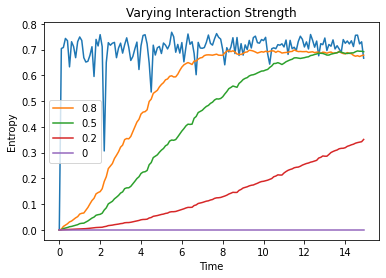

In [210]:
# ===================================== INTEGRATION TESTS =========================================
# Verifying entropy growth over time
def test_int_1():
    H_indv, H_total, w = construct_h_total(0)
    test3 = np.zeros((d**2, d**2), int)
    np.fill_diagonal(test3, 1)
    test3 = np.true_divide(test3,d**2)
    entropies = []
    times = []
    for i in range(1,200):
        new_density = time_evolution(test3, H_total, i*0.1)
        entropies.append(purity_entropy(new_density))
        times.append(i*0.1)
    print(entropies)

    plt.plot(times, entropies)
    plt.xlabel('Time')
    plt.ylabel('Entropy')



#Entropy hould stay at maximal value.
def test_int_1_scrambled():
    H_indv, H_total, w = construct_h_total(0)
    scrambler = generate_random_unitary()
    H_total = (scrambler.dot(H_total)).dot(np.conjugate(np.transpose(scrambler)))
    test3 = np.zeros((d**2, d**2), int)
    np.fill_diagonal(test3, 1)
    test3 = np.true_divide(test3,d**2)
    entropies = []
    times = []
    for i in range(1,200):
        new_density = time_evolution(test3, H_total, i*0.1)
        entropies.append(purity_entropy(construct_reduced_density_a(new_density,d_sys,d_env)))
        times.append(i*0.1)
    plt.plot(times, entropies)
    plt.xlabel('Time')
    plt.ylabel('Entropy')



# Entropy should stay at 0.
def test_int_2():
    H_indv, H_total, w = construct_h_total(0)
    test2 = np.zeros((d,d),int)
    test2[0][0]=1
    entropies = []
    times = []
    for i in range(1,200):
        new_density = time_evolution(test2, H_total, i/3)
        entropies.append(purity_entropy(new_density))
        times.append(i/3)
    print(entropies)
    plt.plot(times, entropies)
    plt.xlabel('Time')
    plt.ylabel('Entropy')


#Verifying entropy of reduced matrix of scrambled, trace over B.
def test_int_3_scrambled(lam):
    plt.clf()
    H_indv, H_total, w = construct_h_total(lam)
    scrambler = generate_random_unitary()
    H_total = (scrambler.dot(H_total)).dot(np.conjugate(np.transpose(scrambler)))
    A = np.zeros((d_sys,d_sys),int)
    A[0][0]=1
    test2 = np.kron(A,A)
    entropies = []
    times = []
    print("Characteristic:", characteristic_time(H_total))
    for i in range(0,150):
        new_density = time_evolution(test2, H_total,0.1*i) #evolve on the whole thing
        entropy = (purity_entropy(construct_reduced_density_a(new_density,d_sys,d_env)))  #trace over for entropy. Reduced density 
        entropies.append(entropy)
        times.append(0.1*i)
    plt.plot(times, entropies)
    plt.xlabel('Time')
    plt.ylabel('Entropy')


#Verifying entropy of reduced matrix of unscrambled, trace over B.
def test_int_3(lam):
    H_indv, H_total, w = construct_h_total(lam)
    A = np.zeros((d_sys,d_sys),int)
    A[0][0]=1
    test2 = np.kron(A,A)
    print("unscrambled Characteristic:", characteristic_time(H_total))
    entropies = []
    times = []
    for i in range(0,150):
        new_density = time_evolution(test2, H_total,0.1*i) #evolve on the whole thing
        entropy = (purity_entropy(construct_reduced_density_a(new_density,d_sys,d_env)))  #trace over for entropy. Reduced density 
        entropies.append(entropy)
        times.append(0.1*i) #0.0001
    plt.plot(times, entropies, label = lam)
    #plt.axvline(x = characteristic_time(H_total), color = 'r', linestyle ='--')
    plt.xlabel('Time')
    plt.ylabel('Entropy')
test_int_3_scrambled(0)
test_int_3(0.8)
test_int_3(0.5)
test_int_3(0.2)
test_int_3(0)
plt.title('Varying Interaction Strength')
plt.legend()
plt.show()


In [15]:
# =================================== PARAMETRIZING UNITARY =======================================

def symmetrical_gmm(j,k,d):
    '''Constructs symmetrical ggm matrices.
    
    Parameters:
    j,k: Indices to be iterated over.
    d: Dimension.
    
    Returns: One symmetrical ggmm.'''
    A = np.zeros((d,d),int)
    A[k][j] = 1
    A[j][k] = 1 
    return A

def antisymmetrical_gmm(j,k,d):
    '''Constructs antisymmetrical ggm matrices.
    
    Parameters:
    j,k: Indices to be iterated over.
    d: Dimension.
    
    Returns: One antisymmetrical ggmm.'''
    A = np.zeros((d,d),complex)
    A[j][k] = -1j
    A[k][j] = 1j 
    return A

def construct_ggmm(lambdas,d):
    '''Constructs full set of symmetrical and  antisymmetrical ggmms.
    
    Parameters:
    lambdas: List of ggmms to append to.
    d: Dimension.
    
    Returns: Antisymmetrical and symmetrical ggmms.'''
    for k in range(1,d):
        for j in range(k):
            lambdas.append(symmetrical_gmm(j,k,d))
            lambdas.append(antisymmetrical_gmm(j,k,d))
    return lambdas

def diagonal_helper(l,d):
    '''Helper function to construct diagonal ggmms.'''
    A = np.zeros((d,d),int)
    for j in range(l):
        A[j][j]=1
    return A

def diagonal_ggmm(lambdas,d):
    '''Function to construct diagonal ggmms.
    
    Parameters:
    lambdas: List of ggmms to append to.
    d: Dimension.
    
    Returns: List of ggmms with diagonal ggmms appended.
    '''
    E_1 = np.zeros((d,d),int)
    for l in range(d-1):
        coeff = math.sqrt(2/((l+1)*(l+2)))
        E_1[l+1][l+1] = 1
        lambdas.append(coeff*((-(l+1)*E_1)+diagonal_helper(l,d)))
        E_1 = np.zeros((d,d),int)
    return lambdas
           
def construct_ggmm_sub(d):
    '''Constructs ggmms for a subsystem of dimension d.
    
    Parameters:
    d: Dimension.
    
    Returns: List of ggmms of dimension d.'''
    lambdas = []
    construct_ggmm(lambdas,d)
    diagonal_ggmm(lambdas,d)
    return lambdas

def tensor_Ib(matrix, ident_b):
    '''Tensors identity matrix of dimension of subsystem b with matrix.'''
    return np.kron(matrix, ident_b)

def tensor_Ia(matrix,ident_a):
    '''Tensors matrix with identity matrix of dimension of subsystem a.'''
    return np.kron(ident_a,matrix)

def construct_all_ggmm(d_a, d_b):
    '''Constructs ggmms for joint system.
    
    Parameters:
    d_a: Dimension of subsystem a.
    d_b: Dimension of subsystem b.
    
    Returns: Complete list of ggmms of dimensions d_a*d_b.'''
    total = []
    a_ggmm = construct_ggmm_sub(d_a)
    b_ggmm = construct_ggmm_sub(d_b)
    ident_b = np.identity(d_b)
    ident_a = np.identity(d_a)
    total.extend([tensor_Ib(x,ident_b) for x in a_ggmm])
    total.extend([tensor_Ia(x,ident_a) for x in b_ggmm])
    for a in a_ggmm:
        for b in b_ggmm:
            total.append(np.kron(a,b))
    return total
    

In [150]:
# ========================= UNITARY TESTS ============================
def correct_len():
    #Verifies list returned by construct_all_ggmm is length D**2-1.
    return ((D**2-1) == len(construct_all_ggmm(d_sys,d_env)))
print(correct_len())

True


In [217]:
lambdas = construct_all_ggmm(d_sys,d_env)

#do characteristic time up here
def scorer(thetas, lam, ham, initial_state):
    '''Parameters:
        thetas: np.array of coefficients to construct unitary matrix from Generalized Gell-Mann matrices.
        lam: Interaction value between 0 and 1.
        ham: Hamiltonian operator to evolve state forward.
        initial_state: State to evolve forward.
        
        Returns: Entropy at the characteristic time for a given unitary matrix.'''
    #Multiply the theta coefficients with the lambda matrices.
    new_lambdas = []
    for i in range(len(thetas)):
        new_lambdas.append(thetas[i]*lambdas[i])
    
    #Sum all scaled matrices then exponentiate to construct unitary scrambler.
    scrambler = np.array(expm(1j*sum(new_lambdas)), dtype=complex)
    
    #Scramble Hamiltonian matrix.
    char_time = characteristic_time(ham)
    H_total = (scrambler.dot(ham)).dot(np.conjugate(np.transpose(scrambler)))
    
    #Evolve intial state forward to characteristic time
    evolved_state = time_evolution(initial_state, H_total,char_time)
    #Take reduced density and find entropy.
    return purity_entropy(construct_reduced_density_a(evolved_state, d_sys,d_env)).real


def scorer_avg(thetas, lam, ham):
    '''Averages the scores produced by the system in every possible basis state and environment in the ready state.
    
    Parameters:
    thetas: Theta coefficient list.
    lam: Lambda coupling coefficient.
    ham: Hamiltonian operator.
    
    Returns: Average score. 
    
    '''
    total = 0 
    B = (1/d_env)*np.ones((d_env,d_env))
    for i in range(d_sys):
        A = np.zeros((d_sys,d_sys),int)
        A[i][i]=1
        initial_state = np.kron(A,B)
        total += scorer(thetas, lam,ham, initial_state)
        #print(total)
    return total/d_sys


def construct_unitary(thetas):
    '''Constructs unitary matrix from thetas.
    
    Parameters:
    thetas: Theta coefficients.
    
    Returns: Unitary matrix.'''
    new_lambdas = []
    for i in range(len(thetas)):
        new_lambdas.append(thetas[i]*lambdas[i])
    
    #Sum all scaled matrices then exponentiate.
    scrambler = np.array(expm(1j*sum(new_lambdas)), dtype=complex)
    return scrambler 

lam=0.8
#unscrambled ham
H_indv, H_total_1, w = construct_h_total(0)
#scrambled ham
#scram_thetas = step_vector_var(3*0.0001)
unitary = construct_unitary(scram_thetas)
H_scram = (unitary.dot(H_total_1)).dot(np.conjugate(np.transpose(unitary)))

thetas = np.array([0]*len(lambdas))
theta_dim1_harmonic_unscrambled = [0.0002, 0.0000, 0.0005,0.0000,0.0001,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000, -0.0000,-0.0000,0.0000,0.0000,-0.0008,0.0000,-0.0004,-0.0000,0.0009,0.0000, -0.0002,-0.0013,0.0001,-0.0010,-0.0000,-0.0018,-0.0002,-0.0009,0.0000,0.0002, -0.0000,-0.0001,-0.0000,-0.0000,0.0003,0.0000,-0.0000,-0.0003,0.0002,-0.0016, 0.0000,-0.0028,-0.0002,-0.0013,0.0000,0.0004,0.0008,-0.0000,0.0001,0.0000, -0.0012,0.0000,0.0003,0.0015,0.0001,-0.0006,0.0000,-0.0010,-0.0001,-0.0005, -0.0000,0.0002,0.0002,0.0001,0.0000,0.0001,-0.0003,-0.0000,0.0000,0.0004, 0.0024,0.0003,0.0003,0.0006,-0.0028,0.0003,0.0003,0.0044]
theta_dim1_anharmonic_unscrambled = [0.0000, -0.0000, -0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000, 0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0001,-0.0000,-0.0001,-0.0000, 0.0001,-0.0000,-0.0000,-0.0003,0.0000,0.0000,-0.0000,0.0003,0.0000,-0.0000, 0.0001,-0.0000,-0.0003,0.0000,0.0001,0.0000,-0.0003,0.0000,-0.0000,-0.0000, 0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0001,-0.0000, -0.0001,-0.0000,0.0001,-0.0000,0.0000,0.0003,-0.0000,-0.0000,0.0000,-0.0003, -0.0000,0.0000,-0.0002,0.0001,0.0003,0.0000,-0.0002,-0.0001,0.0003,-0.0001, 0.0000,-0.0000,-0.0001,0.0000,0.0000,0.0000,-0.0001,0.0000]

print(scorer_avg(theta_dim1_anharmonic_unscrambled,0.8, H_total_1))
print(scorer_avg(thetas,0, H_total_1))

def scorer_ml(thetas):
    '''Scorer function to be passed into the machine learning algorithm.
    
    Parameters:
    thetas: Theta coefficients.
    
    Returns: Result of scorer_avg function.
    '''
    return scorer_avg(thetas,0, H_total_1)

7.401486830834377e-17
3.700743415417188e-17


In [182]:
#TEST
#print(H_scram == H_total_1)

[[False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]]


In [186]:
#TEST
#print(scram_thetas)

[[-0.04235169]
 [ 0.00691565]
 [-0.00675734]
 [-0.01595948]
 [-0.00028739]
 [ 0.02030123]
 [-0.01839282]
 [ 0.01659582]
 [ 0.02096257]
 [ 0.00070584]
 [ 0.02762351]
 [ 0.00278876]
 [-0.0192301 ]
 [-0.02052348]
 [ 0.00738186]
 [ 0.03662585]
 [ 0.01378353]
 [-0.01662699]
 [-0.00929293]
 [-0.03927679]
 [ 0.03553833]
 [ 0.02840605]
 [ 0.00673098]
 [-0.00039802]
 [-0.02306958]
 [-0.0096777 ]
 [-0.02835553]
 [ 0.00644027]
 [-0.03777499]
 [-0.00806511]
 [ 0.0005957 ]
 [ 0.01086532]
 [ 0.00268615]
 [-0.00826707]
 [-0.01233859]
 [ 0.00886266]
 [ 0.01298425]
 [-0.00046739]
 [-0.00293959]
 [-0.00584191]
 [ 0.00988357]
 [ 0.01134349]
 [-0.01066193]
 [-0.02618046]
 [ 0.00065934]
 [ 0.03102108]
 [-0.0189445 ]
 [-0.00963217]
 [ 0.01259488]
 [ 0.02471648]
 [ 0.00223785]
 [-0.0098589 ]
 [-0.01116811]
 [ 0.01300499]
 [-0.01871065]
 [ 0.0315728 ]
 [ 0.01324595]
 [-0.01890217]
 [-0.01576374]
 [ 0.00686822]
 [-0.01203979]
 [ 0.02208687]
 [-0.02699544]
 [ 0.00335365]
 [ 0.02449474]
 [-0.01122307]
 [ 0.01435

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


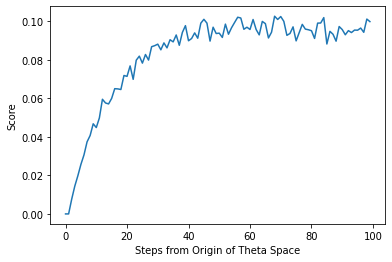

In [218]:
def step_vector(location):
    '''Given an np.array it perturbs the array a step away from the origin.
    
    Parameters:
    location: Array to be moved.
    
    Returns: Array with 0.0001 added to every entry.'''
    return location+0.0001

def step_vector_var(variance):
    '''Parameters:
    variance: Variance of outputted array.
    
    Returns: Array of size D**2-1 with given variance.'''
    #Loc represents the mean and scale the standard deviation, i.e. the square root of variance
    arr = np.random.normal(loc=0, scale=math.sqrt(variance), size=(D**2-1,1))
    return arr

def many_scores(start, steps, lam, ham):
    '''Function to see how entropy increases as theta moves away from origin in theta space.
    
    Parameters:
    start: Starting theta array.
    Steps: Steps to take away from origin.
    lam: Lambda coupling coefficient.
    Ham: Hamiltonian operator.
    
    Returns: Plot of score vs distance from origin in theta space.'''
    scores = np.zeros(steps, dtype=complex)
    distances = np.array(range(steps))
    for i in range(steps):
        scores[i] = (scorer_avg(start, lam, ham))
        start = step_vector_var(i*0.0001)
    plt.plot(distances, scores, label = lam)
    plt.xlabel('Steps from Origin of Theta Space')
    plt.ylabel('Score')

H_indv, H_total_1, w = construct_h_total(0.8)
#many_scores(np.array([0]*len(construct_all_ggmm(d_sys, d_env))), 100, 0.2)
many_scores(np.array([0]*len(construct_all_ggmm(d_sys, d_env))), 100,0.8, H_total_1)
plt.show()
#plt.legend()

In [207]:
#### ========== Machine Learning Algorithm ============== ###
from scipy.optimize import basinhopping
minimizer_kwargs = {"method":"L-BFGS-B"}
x0 = np.array([0]*len(construct_all_ggmm(d_sys,d_env)))
print(len(x0))
ret = basinhopping(scorer_ml, x0, minimizer_kwargs=minimizer_kwargs,
                   niter=100)
print( "global minimum: x = [%.4f, %.4f, %.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f, %.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f, %.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f, %.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f, %.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f, %.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f, %.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f, %.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f], f(x0) = %.4f" % (ret.x[0],
                                                          ret.x[1],ret.x[2],ret.x[3],ret.x[4],ret.x[5],ret.x[6],ret.x[7],ret.x[8],ret.x[9],ret.x[10],
                                                          ret.x[11],ret.x[12],ret.x[13],ret.x[14],ret.x[15],ret.x[16],ret.x[17],ret.x[18],ret.x[19],ret.x[20],
                                                          ret.x[21],ret.x[22],ret.x[23],ret.x[24],ret.x[25],ret.x[26],ret.x[27],ret.x[28],ret.x[29],ret.x[30],
                                                          ret.x[31],ret.x[32],ret.x[33],ret.x[34],ret.x[35],ret.x[36],ret.x[37],ret.x[38],ret.x[39],ret.x[40],
                                                          ret.x[41],ret.x[42],ret.x[43],ret.x[44],ret.x[45],ret.x[46],ret.x[47],ret.x[48],ret.x[49],ret.x[50],
                                                          ret.x[51],ret.x[52],ret.x[53],ret.x[54],ret.x[55],ret.x[56],ret.x[57],ret.x[58],ret.x[59],ret.x[60],
                                                          ret.x[61],ret.x[62],ret.x[63],ret.x[64],ret.x[65],ret.x[66],ret.x[67],ret.x[68],ret.x[69],ret.x[70],
                                                          ret.x[71],ret.x[72],ret.x[73],ret.x[74],ret.x[75],ret.x[76],ret.x[77],ret.x[78],ret.x[79],
                                                          ret.fun))


80
global minimum: x = [0.0000, 0.0000, 0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000, 0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000, 0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000, 0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000, 0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000, 0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000, 0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000, 0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000], f(x0) = 0.0000


In [185]:
#Comparing scores
theta_dim1_anharmonic_scrambled = [0.0994, -0.6651, 0.1377,-0.3459,-0.1955,-0.3854,-0.4809,0.3988,-0.3252,0.0777,0.3959,-0.0213, 0.2747,-0.3109,0.2839,0.2451,0.2458,0.1289,0.1567,-0.0908,0.1004,0.2313, 0.4868,-0.4240,-0.1708,-0.0938,-0.1404,0.3604,-0.0354,-0.1123,-0.2355,0.2545, 0.2602,0.3554,0.3359,-0.3274,0.2310,-0.1279,0.2609,-0.0767,-0.4925,0.0725, 0.3310,-0.2613,0.0840,0.1619,0.0177,-0.4002,0.2297,0.1911,-0.1912,-0.1296, 0.0666,0.1177,0.0190,0.0388,-0.0361,-0.0183,0.2410,0.0950,0.2188,-0.5062, 0.2958,-0.2467,0.0158,-0.1650,0.0116,0.1427,-0.3453,-0.0420,-0.1642,0.1550, 0.1664,0.1784,0.0579,0.0817,-0.4336,0.1438,-0.3022,-0.0282]
print(scorer_avg(theta_dim1_anharmonic_scrambled,0.8,H_scram))
print(scorer_avg(thetas,0.8, H_scram))

3.0889332943336476e-09
0.0024497253240021535


In [198]:
#Comparing distances of norms of matrices.
ml_distance = norm(unitary,1) - norm(construct_unitary(theta_dim1_anharmonic_scrambled))
avg_distance = norm(construct_unitary(step_vector_var(100)),1) - norm(construct_unitary(step_vector_var(.000000005)),1)

print(ml_distance)
print(avg_distance)

-1.6956798527008359
1.823692258077323


Complete starting state
 [[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]]
Complete starting state
 [[0.5 0.5 0.  0. ]
 [0.5 0.5 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
evovled state
 [[0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]] 2 2
evolved score (8.881784197001252e-16+0j) Just about 0.
new hami
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.23711432e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
evovled state
 [[5.00000000e-01+0.00000000e+00j 5.00000000e-01+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [5.00000000e-01+0.00000000e+00j 5.00000000e-01+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [2.23711432e-17+6.25858165e-

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


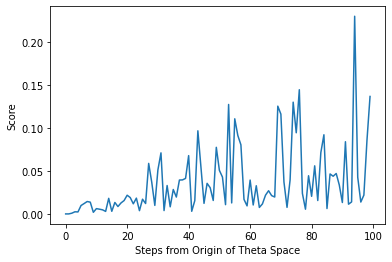

In [214]:
#==================== SYSTEM OF QUBITS ===============================
def test_scorer(initial_state, ham):
    evolved = expm(-(1j)*ham*math.pi).dot(initial_state).dot(expm((1j)*ham*math.pi))
    print("evolved state\n",evolved, 2,2)
    return purity_entropy(construct_reduced_density_a(evolved, 2,2))

lambs = construct_all_ggmm(2,2)
def gen_scorer(theta, initial_state, ham):
    '''Parameters:
        thetas: np.array of coefficients to construct unitary matrix from Generalized Gell-Mann matrices.
        initial_state: State to evolve forward.
        ham: Hamiltonian operator to evolve state forward.
        
        Returns: Entropy at the characteristic time for a given unitary matrix.'''
    new_lambdas = []
    for i in range(len(theta)):
        new_lambdas.append(theta[i]*lambs[i])
    
    #Sum all scaled matrices then exponentiate.
    scrambler = np.array(expm(1j*sum(new_lambdas)), dtype=complex)
    H_total = (scrambler.dot(ham)).dot(np.conjugate(np.transpose(scrambler)))
    evolved = expm(-(1j)*H_total*math.pi).dot(initial_state).dot(expm((1j)*H_total*math.pi))
    return purity_entropy(construct_reduced_density_a(evolved, 2,2))
    
def step_vector_var_gen(variance,dim):
    '''Parameters:
    variance: Variance of outputted array.
    dim: Dimension of array.
    
    Returns: Array of size d with given variance.'''
    #Loc represents the mean and scale the standard deviation, i.e. the square root of variance
    arr = np.random.normal(loc=0, scale=math.sqrt(variance), size=(dim,1))
    return arr


def many_scores_gen(start,ham,initial_state1,initial_state2, steps):
    '''Function to see how entropy increases as theta moves away from origin in theta space.
    
    Parameters:
    start: Starting theta array.
    ham: Hamiltonian operator.
    initial_state1: 1st basis state of system.
    initial_state2: 2nd basis state of system.
    steps: Steps to take away from origin.
    
    Returns: Plot of score vs distance from origin in theta space.'''
    scores = np.zeros(steps, dtype=complex)
    distances = np.array(range(steps))
    for i in range(steps):
        score_1 = (gen_scorer(start,initial_state1,ham))
        score_2 = (gen_scorer(start,initial_state2,ham))
        scores[i] = (score_1+score_2)/2
        start = step_vector_var_gen(i*0.0001, 15)
    plt.plot(distances, scores)
    plt.xlabel('Steps from Origin of Theta Space')
    plt.ylabel('Score')

#Constructing and evolving system of 2 qubits.
a_1 = [[1,0]]
a_2 = [[0,1]]
b_1 = [[1/math.sqrt(2),1/math.sqrt(2)]]
hami =np.matrix([[0,0,0,0],[0,0,0,0],[0,0,0.5,-0.5],[0,0,-0.5,0.5]])
scramble = np.matrix([[1/math.sqrt(2),1/math.sqrt(2),0,0],[0,0,1/math.sqrt(2),1/math.sqrt(2)],[0,0,1/math.sqrt(2),-1/math.sqrt(2)],[1/math.sqrt(2),-1/math.sqrt(2),0,0]])
state = np.kron(a_1, b_1)
state2 = np.kron(a_2, b_1)
full_state = state * state.transpose()
full_state2 = state2 * state2.transpose()

print("Complete starting state\n", full_state2)
print("Complete starting state\n", full_state)
print("evolved score", test_scorer(full_state, hami), "Just about 0.")
print("new hami\n",(scramble.dot(hami)).dot(np.conjugate(np.transpose(scramble))))
print("scrambled score", test_scorer(full_state,(scramble.dot(hami)).dot(np.conjugate(np.transpose(scramble)))),"Just about 0.")
                     
many_scores_gen(np.array([0]*len(lambs)), hami, full_state,full_state2, 100)